In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load datasets
print("Loading datasets...")
admissions = pd.read_csv('../datasets/admissions_202208161605.csv')
patients = pd.read_csv('../datasets/patients_202208161605.csv')
diagnoses_icd = pd.read_csv('../datasets/diagnoses_icd_202208161605.csv')
labevents = pd.read_csv('../datasets/labevents_202208161605.csv')
d_labitems = pd.read_csv('../datasets/d_labitems_202208161605.csv')
procedures_icd = pd.read_csv('../datasets/procedures_icd_202208161605.csv')
cptevents = pd.read_csv('../datasets/cptevents_202208161605.csv')
drgcodes = pd.read_csv('../datasets/drgcodes_202208161605.csv')


Loading datasets...


In [3]:
print("Dataset shapes:")
print(f"Admissions: {admissions.shape}")
print(f"Patients: {patients.shape}")
print(f"Diagnoses ICD: {diagnoses_icd.shape}")
print(f"Lab Events: {labevents.shape}")
print(f"Lab Items: {d_labitems.shape}")
print(f"Procedures ICD: {procedures_icd.shape}")
print(f"CPT Events: {cptevents.shape}")
print(f"DRG Codes: {drgcodes.shape}")

Dataset shapes:
Admissions: (58976, 19)
Patients: (46520, 8)
Diagnoses ICD: (651047, 5)
Lab Events: (27854055, 9)
Lab Items: (753, 6)
Procedures ICD: (240095, 5)
CPT Events: (573146, 12)
DRG Codes: (125557, 8)


In [4]:
# Display basic info
print("\nAdmissions Info:")
print(admissions.info())
print("\nPatients Info:")
print(patients.info())

# Heart failure ICD codes
heart_failure_codes = [
    '39891','40201','40211','40291','40401','40403','40411','40413',
    '40491','40493','4280','4281','42820','42821','42822','42823',
    '42830','42831','42832','42833','42840','42841','42842','42843','4289'
]

print(f"\nHeart Failure ICD Codes: {len(heart_failure_codes)}")


Admissions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                58976 non-null  int64 
 1   subject_id            58976 non-null  int64 
 2   hadm_id               58976 non-null  int64 
 3   admittime             58976 non-null  object
 4   dischtime             58976 non-null  object
 5   deathtime             5854 non-null   object
 6   admission_type        58976 non-null  object
 7   admission_location    58976 non-null  object
 8   discharge_location    58976 non-null  object
 9   insurance             58976 non-null  object
 10  language              33644 non-null  object
 11  religion              58518 non-null  object
 12  marital_status        48848 non-null  object
 13  ethnicity             58976 non-null  object
 14  edregtime             30877 non-null  object
 15  edouttime         

In [6]:
# Identify heart failure patients
hf_diagnoses = diagnoses_icd[diagnoses_icd['icd9_code'].isin(heart_failure_codes)]
print(f"Number of unique heart failure admissions: {hf_diagnoses['hadm_id'].nunique()}")
print(f"Number of unique heart failure patients: {hf_diagnoses['subject_id'].nunique()}")

# Merge with admissions to get more details
hf_admissions = hf_diagnoses.merge(admissions, on=['subject_id', 'hadm_id'], how='left')
hf_admissions = hf_admissions.merge(patients, on='subject_id', how='left')

print(f"\nHeart Failure Admissions shape: {hf_admissions.shape}")

# Convert date columns
hf_admissions['admittime'] = pd.to_datetime(hf_admissions['admittime'])
hf_admissions['dischtime'] = pd.to_datetime(hf_admissions['dischtime'])
hf_admissions['dob'] = pd.to_datetime(hf_admissions['dob'])
# --- SAFE AGE CALCULATION (prevents OverflowError) ---

# Convert date columns safely
hf_admissions['admittime'] = pd.to_datetime(hf_admissions['admittime'], errors='coerce')
hf_admissions['dob'] = pd.to_datetime(hf_admissions['dob'], errors='coerce')

# Remove invalid or extreme dates
min_date = pd.Timestamp('1900-01-01')
max_date = pd.Timestamp('today') + pd.Timedelta(days=1)
hf_admissions.loc[
    (hf_admissions['dob'] < min_date) | (hf_admissions['dob'] > max_date), 'dob'
] = pd.NaT
hf_admissions.loc[
    (hf_admissions['admittime'] < min_date) | (hf_admissions['admittime'] > max_date), 'admittime'
] = pd.NaT

# Ensure DOB is not after admission date
hf_admissions.loc[hf_admissions['dob'] > hf_admissions['admittime'], 'dob'] = pd.NaT

# Compute age only where both dates are valid
valid_mask = hf_admissions['dob'].notna() & hf_admissions['admittime'].notna()
hf_admissions.loc[valid_mask, 'age'] = (
    (hf_admissions.loc[valid_mask, 'admittime'] - hf_admissions.loc[valid_mask, 'dob']).dt.days / 365.25
)

# Remove unrealistic ages (>120 years)
hf_admissions.loc[hf_admissions['age'] > 120, 'age'] = np.nan

# Convert to integer safely
hf_admissions['age'] = hf_admissions['age'].fillna(0).astype(int)

print("✅ Age calculated safely without overflow.")


Number of unique heart failure admissions: 14040
Number of unique heart failure patients: 10436

Heart Failure Admissions shape: (21274, 29)
✅ Age calculated safely without overflow.



Basic Statistics for Heart Failure Patients:
           age  los
count  21274.0  0.0
mean       0.0  NaN
std        0.0  NaN
min        0.0  NaN
25%        0.0  NaN
50%        0.0  NaN
75%        0.0  NaN
max        0.0  NaN


Text(0, 0.5, 'Count')

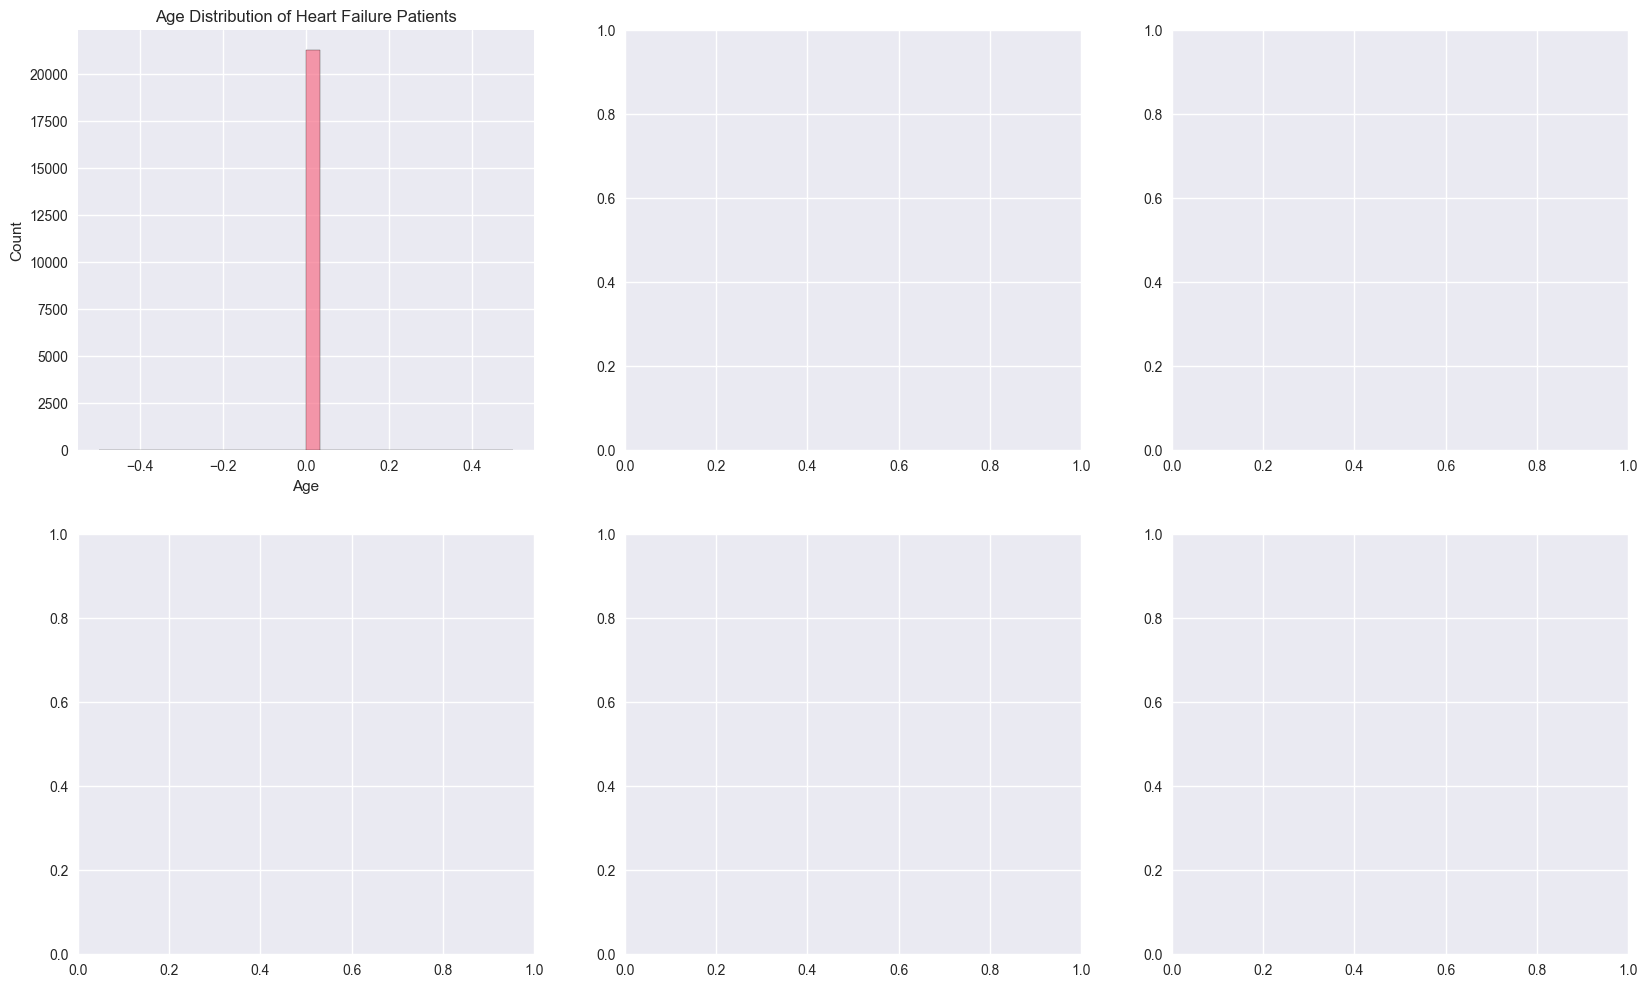

In [7]:
# Length of stay
hf_admissions['los'] = (hf_admissions['dischtime'] - hf_admissions['admittime']).dt.days

print("\nBasic Statistics for Heart Failure Patients:")
print(hf_admissions[['age', 'los']].describe())

# Demographic analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Age distribution
axes[0,0].hist(hf_admissions['age'], bins=30, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Age Distribution of Heart Failure Patients')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Count')

In [9]:
# Gender distribution
gender_counts = hf_admissions['gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axes[0,1].set_title('Gender Distribution')

# --- Compute Length of Stay (LOS) safely ---
hf_admissions['admittime'] = pd.to_datetime(hf_admissions['admittime'], errors='coerce')
hf_admissions['dischtime'] = pd.to_datetime(hf_admissions['dischtime'], errors='coerce')

# Compute LOS in days only for valid rows
valid_los_mask = hf_admissions['dischtime'].notna() & hf_admissions['admittime'].notna()
hf_admissions.loc[valid_los_mask, 'los'] = (
    (hf_admissions.loc[valid_los_mask, 'dischtime'] - hf_admissions.loc[valid_los_mask, 'admittime']).dt.days
)

# Remove unrealistic or negative LOS values
hf_admissions.loc[hf_admissions['los'] < 0, 'los'] = np.nan
hf_admissions.loc[hf_admissions['los'] > 365, 'los'] = np.nan  # Optional: exclude >1-year stays

# --- Plot Length of Stay safely ---
los_clean = hf_admissions['los'].dropna()

if len(los_clean) > 0:
    axes[0,2].hist(los_clean, bins=30, edgecolor='black', alpha=0.7)
    axes[0,2].set_title('Length of Stay Distribution')
    axes[0,2].set_xlabel('Days')
    axes[0,2].set_ylabel('Count')
else:
    axes[0,2].text(0.5, 0.5, 'No valid LOS data', ha='center', va='center', fontsize=12)
    axes[0,2].set_axis_off()

print("✅ Length of stay plotted successfully.")


# Admission type
admission_type_counts = hf_admissions['admission_type'].value_counts()
axes[1,0].bar(admission_type_counts.index, admission_type_counts.values)
axes[1,0].set_title('Admission Type Distribution')
axes[1,0].tick_params(axis='x', rotation=45)

# Ethnicity (top 10)
ethnicity_counts = hf_admissions['ethnicity'].value_counts().head(10)
axes[1,1].barh(ethnicity_counts.index, ethnicity_counts.values)
axes[1,1].set_title('Top 10 Ethnicities')

✅ Length of stay plotted successfully.


Text(0.5, 1.0, 'Top 10 Ethnicities')

In [10]:
# Insurance
insurance_counts = hf_admissions['insurance'].value_counts()
axes[1,2].bar(insurance_counts.index, insurance_counts.values)
axes[1,2].set_title('Insurance Distribution')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mortality analysis
mortality_rate = hf_admissions['hospital_expire_flag'].mean()
print(f"\nIn-hospital mortality rate: {mortality_rate:.2%}")

# Readmission analysis
print("\nAnalyzing readmissions...")
hf_admissions_sorted = hf_admissions.sort_values(['subject_id', 'admittime'])

<Figure size 800x550 with 0 Axes>


In-hospital mortality rate: 13.09%

Analyzing readmissions...


In [11]:
# Calculate time to next admission
hf_admissions_sorted['next_admittime'] = hf_admissions_sorted.groupby('subject_id')['admittime'].shift(-1)
hf_admissions_sorted['days_to_readmit'] = (hf_admissions_sorted['next_admittime'] - hf_admissions_sorted['dischtime']).dt.days

# Define 30-day readmission
hf_admissions_sorted['readmission_30'] = (hf_admissions_sorted['days_to_readmit'] <= 30).astype(int)

# For the last admission of each patient, we don't know if they were readmitted
# So we'll mark those as NaN and then fill with 0 for modeling purposes
hf_admissions_sorted.loc[hf_admissions_sorted['next_admittime'].isna(), 'readmission_30'] = 0

readmission_rate = hf_admissions_sorted['readmission_30'].mean()
print(f"30-day readmission rate: {readmission_rate:.2%}")

# Save the base dataset for preprocessing
hf_admissions_sorted.to_csv('../datasets/heart_failure_base.csv', index=False)
print("\nBase dataset saved for preprocessing.")

30-day readmission rate: 0.00%

Base dataset saved for preprocessing.
